In [38]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### 读取原始数据

In [39]:
df = pd.read_csv("Tianchi_power.csv")
df['record_date'] = pd.to_datetime(df['record_date'])
df.head()

,record_date,user_id,power_consumption
0,2015-01-01,1,1135
1,2015-01-02,1,570
2,2015-01-03,1,3418
3,2015-01-04,1,3968
4,2015-01-05,1,3986


### 填充缺省值

In [40]:
dates = pd.date_range("2015-01-01","2016-08-31", freq="1D")
userid = pd.DataFrame({'user_id':df['user_id'].unique()})
dates = pd.DataFrame(dates)
dates.columns = ['record_date']
userid['key'] = 0
dates['key'] = 0
full = userid.merge(dates, how='left', on = 'key')
full.drop('key',1, inplace=True)
full.head(2)

,user_id,record_date
0,1,2015-01-01
1,1,2015-01-02


In [41]:
df = pd.merge(full, df, how='left', on=['user_id','record_date'])
df['power_consumption'] = df['power_consumption'].interpolate()
df.shape

(885486, 3)

### 填充特征

In [42]:
df['dow'] = df['record_date'].apply(lambda x: x.dayofweek)
df['doy'] = df['record_date'].apply(lambda x: x.dayofyear)
df['day'] = df['record_date'].apply(lambda x: x.day)
df['month'] = df['record_date'].apply(lambda x: x.month)
df['year'] = df['record_date'].apply(lambda x: x.year)

def map_season(month):
    month_dic = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3, 9:3, 10:4, 11:4, 12:1}
    return month_dic[month]

df['season'] = df['month'].apply(lambda x: map_season(x))

In [43]:
### 用电量聚合到一个月

base_df = df[['record_date','power_consumption']].groupby(by='record_date').agg('sum')
base_df = base_df.reset_index()
base_df.head()
base_df.shape
# df = base_df

(609, 2)

### 拼接测试集

In [44]:
df_test = base_df[(base_df.record_date>='2016-08-01')&(base_df.record_date<='2016-08-30')]
df_test['record_date'] = pd.DataFrame(df_test['record_date']+pd.Timedelta('31 days'))
df_test.head()

,record_date,power_consumption
578,2016-09-01,4627029.0
579,2016-09-02,4618467.0
580,2016-09-03,4490739.0
581,2016-09-04,4367727.0
582,2016-09-05,4253298.0


In [45]:
df = pd.concat([base_df, df_test]).sort_values(['record_date'])
# base_df.shape

# df = base_df
df.head()

,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


In [46]:
base_df = df
df.head()

,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


### 造特征

In [47]:
base_df['dow'] = base_df['record_date'].apply(lambda x: x.dayofweek)
base_df['doy'] = base_df['record_date'].apply(lambda x: x.dayofyear)
base_df['day'] = base_df['record_date'].apply(lambda x: x.day)
base_df['month'] = base_df['record_date'].apply(lambda x: x.month)
base_df['year'] = base_df['record_date'].apply(lambda x: x.year)

def map_season(month):
    month_dic = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3, 9:3, 10:4, 11:4, 12:1}
    return month_dic[month]

# base_df['season'] = base_df['month'].apply(lambda x: map_season(x))

### 添加更多特征
### 先添加前一个月的均值和方差

In [48]:
df_stats = base_df[['power_consumption','year','month']].groupby(by=['year', 'month']).agg(['mean', 'std'])
df_stats.head()

df_stats.columns = df_stats.columns.droplevel(0)
df_stats = df_stats.reset_index()
df_stats.head()
df_stats['mean'] = df_stats['mean'].shift(1)
# df_stats['2_m_mean'] = df_stats['mean'].shift(2)
df_stats['std'] = df_stats['std'].shift(1)
# df_stats['2_m_std'] = df_stats['std'].shift(2)
df_stats.head()

,year,month,mean,std
0,2015,1,NaN,NaN
1,2015,2,3.961383e+06,303629.486622
2,2015,3,2.795163e+06,769697.864999
3,2015,4,3.478852e+06,564753.747993
4,2015,5,3.768333e+06,190787.832757


In [51]:
# train = pd.merge('base_df','df_stats',on=['year','month'])
train = pd.merge(base_df, df_stats, how='left', on=['year','month'])
train.head()

,record_date,power_consumption,dow,doy,day,month,year,mean,std
0,2015-01-01,2900575.0,3,1,1,1,2015,NaN,NaN
1,2015-01-02,3158211.0,4,2,2,1,2015,NaN,NaN
2,2015-01-03,3596487.0,5,3,3,1,2015,NaN,NaN
3,2015-01-04,3939672.0,6,4,4,1,2015,NaN,NaN
4,2015-01-05,4101790.0,0,5,5,1,2015,NaN,NaN


### 把一个月分成上下 半月
### 用它们的均值之差表示数据上下起伏趋势

In [52]:
# 先对一个月做切分
def month_half(day):
    if day>=1 and day<=15:
        return 1
    else:
        return 2

base_df['month_half'] = base_df['day'].apply(lambda x:month_half(x))
# base_df['week_period'] = base_df['day'].apply(lambda x:week_period(x))

half = base_df[['power_consumption','year','month','month_half']].groupby(by=['year', 'month', 'month_half']).agg('mean')
half = half.reset_index()
half.head()

half['month_half'] = half['power_consumption'].diff(1)
month_period_df = half.drop('power_consumption',1)
# half.head()

month_period_df = month_period_df[['year','month','month_half']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
month_period_df = month_period_df.reset_index()
month_period_df[['first_half','second_half']] =  month_period_df['month_half'].str.split(',', expand=True) 
month_period_df = month_period_df.drop('month_half',1)

# month_1_columns = [tmp+'_1month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
month_period_df[['first_half','second_half']] = month_period_df[['first_half','second_half']].shift(1)
# month_2_columns = [tmp+'_2month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
# month_period_df[month_2_columns] = month_period_df[['month_period_1', 'month_period_2','month_period_3']].shift(2)

month_period_df.head()

,year,month,first_half,second_half
0,2015,1,NaN,NaN
1,2015,2,nan,156902.8125
2,2015,3,-674272.145833,-1223101.62821
3,2015,4,1219955.32821,230498.695833
4,2015,5,164766.270833,26365.9333333


In [54]:
# 合并
train =  pd.merge(train, month_period_df, how='left', on=['year','month'])
train.head()

,record_date,power_consumption,dow,doy,day,month,year,mean,std,first_half,second_half
0,2015-01-01,2900575.0,3,1,1,1,2015,NaN,NaN,NaN,NaN
1,2015-01-02,3158211.0,4,2,2,1,2015,NaN,NaN,NaN,NaN
2,2015-01-03,3596487.0,5,3,3,1,2015,NaN,NaN,NaN,NaN
3,2015-01-04,3939672.0,6,4,4,1,2015,NaN,NaN,NaN,NaN
4,2015-01-05,4101790.0,0,5,5,1,2015,NaN,NaN,NaN,NaN


### 把一个月分成上中下旬3个month_periods 或者 4周总共4个week_periods
### 用它们的均值之差表示数据上下起伏趋势

In [55]:
# 先对一个月做切分
def month_period(day):
    if day>=1 and day<=10:
        return 1
    elif day>=11 and day<=20:
        return 2
    else:
        return 3

def week_period(day):
    if day>=1 and day<=7:
        return 1
    elif day>=8 and day<=14:
        return 2
    elif day>=15 and day<=21:
        return 3
    else:
        return 4

base_df['month_period'] = base_df['day'].apply(lambda x:month_period(x))
base_df['week_period'] = base_df['day'].apply(lambda x:week_period(x))

### 按照period求均值

In [56]:
month_period_df = base_df[['power_consumption','year','month','month_period']].groupby(by=['year', 'month', 'month_period']).agg('mean')
month_period_df = month_period_df.reset_index()
month_period_df.head()

,year,month,month_period,power_consumption
0,2015,1,1,3.825766e+06
1,2015,1,2,4.016926e+06
2,2015,1,3,4.034177e+06
3,2015,2,1,3.691394e+06
4,2015,2,2,2.338909e+06


### 求出来均值之差

In [57]:
month_period_df['month_period'] = month_period_df['power_consumption'].diff(1)
month_period_df = month_period_df.drop('power_consumption',1)
month_period_df.head()

,year,month,month_period
0,2015,1,NaN
1,2015,1,1.911600e+05
2,2015,1,1.725125e+04
3,2015,2,-3.427832e+05
4,2015,2,-1.352486e+06


### 填充上个月和上上个月的趋势数据

In [58]:
month_period_df = month_period_df[['year','month','month_period']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
month_period_df = month_period_df.reset_index()
month_period_df[['month_period_1','month_period_2','month_period_3']] =  month_period_df['month_period'].str.split(',', expand=True) 
month_period_df = month_period_df.drop('month_period',1)

# month_1_columns = [tmp+'_1month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
month_period_df[['month_period_1', 'month_period_2','month_period_3']] = month_period_df[['month_period_1', 'month_period_2','month_period_3']].shift(1)
# month_2_columns = [tmp+'_2month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
# month_period_df[month_2_columns] = month_period_df[['month_period_1', 'month_period_2','month_period_3']].shift(2)

month_period_df.head()

,year,month,month_period_1,month_period_2,month_period_3
0,2015,1,NaN,NaN,NaN
1,2015,2,nan,191160.0,17251.2545455
2,2015,3,-342783.154545,-1352485.7,-93716.5375
3,2015,4,863222.6375,559158.05,-23522.6590909
4,2015,5,109222.009091,-25469.75,96123.1


In [59]:
# 合并
train_mon =  pd.merge(train, month_period_df, how='left', on=['year','month'])
train_mon.head()

,record_date,power_consumption,dow,doy,day,month,year,mean,std,first_half,second_half,month_period_1,month_period_2,month_period_3
0,2015-01-01,2900575.0,3,1,1,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,3158211.0,4,2,2,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,3596487.0,5,3,3,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,3939672.0,6,4,4,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,4101790.0,0,5,5,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
week_period_df = base_df[['power_consumption','year','month','week_period']].groupby(by=['year', 'month', 'week_period']).agg('mean')
week_period_df = week_period_df.reset_index()
# week_period_df.head()

In [61]:
week_period_df['week_period'] = week_period_df['power_consumption'].diff(1)
week_period_df = week_period_df.drop('power_consumption',1)
# week_period_df.head()

In [62]:
# 将每个月中四个周的值分为四列。
week_period_df = week_period_df[['year','month','week_period']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
week_period_df = week_period_df.reset_index()
week_period_df[['week_period_1','week_period_2','week_period_3','week_period_4']] =  week_period_df['week_period'].str.split(',', expand=True) 
week_period_df = week_period_df.drop('week_period',1)

add_columns_1 = [tmp+'_1month' for tmp in ['week_period_1', 'week_period_2','week_period_3', 'week_period_4']]
week_period_df[['week_period_1','week_period_2','week_period_3','week_period_4']] = week_period_df[['week_period_1', 'week_period_2','week_period_3', 'week_period_4']].shift(1)
# add_columns_2 = [tmp+'_2month' for tmp in ['week_period_1', 'week_period_2','week_period_3', 'week_period_4']]
# week_period_df[add_columns_2] = week_period_df[['week_period_1', 'week_period_2','week_period_3', 'week_period_4']].shift(2)

week_period_df.head()

,year,month,week_period_1,week_period_2,week_period_3,week_period_4
0,2015,1,NaN,NaN,NaN,NaN
1,2015,2,nan,297703.428571,46736.2857143,-31404.2714286
2,2015,3,-220744.014286,-739169.857143,-1042483.85714,252348.357143
3,2015,4,645923.071429,821015.214286,-292440.071429,245783.857143
4,2015,5,-9620.85714286,113845.428571,-66743.6428571,91990.9047619


In [63]:
# 添加 week period 相关特征
df_final = pd.merge(train_mon, week_period_df, how='left', on=['year','month'])

In [64]:
# df_final.head()

In [65]:
df_final.columns

Index([u'record_date', u'power_consumption', u'dow', u'doy', u'day', u'month',
       u'year', u'mean', u'std', u'first_half', u'second_half',
       u'month_period_1', u'month_period_2', u'month_period_3',
       u'week_period_1', u'week_period_2', u'week_period_3', u'week_period_4'],
      dtype='object')

### 去掉不需要的数据

In [66]:
df_final = df_final[df_final.record_date>='2015-03-01']
# df_final['previous_2months_diff'] = df_final['1_m_mean']-df_final['2_m_mean']
df_final.head()

,record_date,power_consumption,dow,doy,day,month,year,mean,std,first_half,second_half,month_period_1,month_period_2,month_period_3,week_period_1,week_period_2,week_period_3,week_period_4
59,2015-03-01,2900464.0,6,60,1,3,2015,2.795163e+06,769697.864999,-674272.145833,-1223101.62821,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1042483.85714,252348.357143
60,2015-03-02,3334082.0,0,61,2,3,2015,2.795163e+06,769697.864999,-674272.145833,-1223101.62821,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1042483.85714,252348.357143
61,2015-03-03,3492606.0,1,62,3,3,2015,2.795163e+06,769697.864999,-674272.145833,-1223101.62821,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1042483.85714,252348.357143
62,2015-03-04,3597890.0,2,63,4,3,2015,2.795163e+06,769697.864999,-674272.145833,-1223101.62821,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1042483.85714,252348.357143
63,2015-03-05,1798044.0,3,64,5,3,2015,2.795163e+06,769697.864999,-674272.145833,-1223101.62821,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1042483.85714,252348.357143


### 异常值

In [67]:
# df1 = df_final[(df_final.record_date >= '2016-03-01')]#
# df2 = df_final[(df_final.record_date < '2016-01-01')]#
# # df_final = df_final[(df_final.record_date >= '2016-03-01')]#| (df_final.record_date < '2016-01-01')]
# # df_final['previous_2months_diff'] = df_final['1_m_mean']-df_final['2_m_mean']
# df_final = pd.concat([df2,df1])
# df_final.head()

In [68]:
## 
df_final.record_date.unique()

array(['2015-03-01T00:00:00.000000000', '2015-03-02T00:00:00.000000000',
       '2015-03-03T00:00:00.000000000', '2015-03-04T00:00:00.000000000',
       '2015-03-05T00:00:00.000000000', '2015-03-06T00:00:00.000000000',
       '2015-03-07T00:00:00.000000000', '2015-03-08T00:00:00.000000000',
       '2015-03-09T00:00:00.000000000', '2015-03-10T00:00:00.000000000',
       '2015-03-11T00:00:00.000000000', '2015-03-12T00:00:00.000000000',
       '2015-03-13T00:00:00.000000000', '2015-03-14T00:00:00.000000000',
       '2015-03-15T00:00:00.000000000', '2015-03-16T00:00:00.000000000',
       '2015-03-17T00:00:00.000000000', '2015-03-18T00:00:00.000000000',
       '2015-03-19T00:00:00.000000000', '2015-03-20T00:00:00.000000000',
       '2015-03-21T00:00:00.000000000', '2015-03-22T00:00:00.000000000',
       '2015-03-23T00:00:00.000000000', '2015-03-24T00:00:00.000000000',
       '2015-03-25T00:00:00.000000000', '2015-03-26T00:00:00.000000000',
       '2015-03-27T00:00:00.000000000', '2015-03-28

### 保存测试集

In [69]:
df_final = df_final.drop(['record_date'],1)
df_final.to_csv('train0529.csv', index=False)

In [70]:
### 生成训练集和测试集

import pandas as pd
df_final = pd.read_csv('train0529.csv')

# df_final = df_final.drop('record_date',1)

final_train_data = df_final[~((df_final.year==2016)&(df_final.month==9))].drop(['power_consumption'],1)
final_train_data = final_train_data.astype(float)
final_test_data = df_final[((df_final.year==2016)&(df_final.month==9))].drop(['power_consumption'],1)
final_test_data = final_test_data.astype(float)
train_target = df_final[~((df_final.year==2016)&(df_final.month==9))][['power_consumption']]

train_lgb = final_train_data.copy()
train_lgb[['dow','doy','day','month','year']] = train_lgb[['dow','doy','day','month','year']]\
.astype(str)
test_lgb = final_test_data.copy()
test_lgb[['dow','doy','day','month','year']] = test_lgb[['dow','doy','day','month','year',]]\
.astype(str)

X_lgb = train_lgb.values
y_lgb = train_target.values.reshape(train_target.values.shape[0],)
print y_lgb[0]
print X_lgb[0,:]

#随机敲定一组参数跑模型
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_lgb, y_lgb)
# specify your configurations as a dict
params = {
    'num_leaves': 1024,
    'learning_rate':0.42,
    'n_estimators':30,
    'feature_fraction': 1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

print('Start training...')
# train

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=30,
                feature_name=list(final_train_data.columns))


# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=30,
# #                 valid_sets=[lgb_train, lgb_test],
#                 feature_name=list(final_train_data.columns)),
# #                 categorical_feature=[21],
#                 evals_result=evals_result,
# #                 verbose_eval=10
#         )
df_final.head()

2900464.0
['6.0' '60.0' '1.0' '3.0' '2015.0' 2795163.05357 769697.864999
 -674272.145833 -1223101.62821 -342783.154545 -1352485.7 -93716.5375
 -220744.01428600002 -739169.857143 -1042483.85714 252348.35714299997]
Start training...


,power_consumption,dow,doy,day,month,year,mean,std,first_half,second_half,month_period_1,month_period_2,month_period_3,week_period_1,week_period_2,week_period_3,week_period_4
0,2900464.0,6,60,1,3,2015,2.795163e+06,769697.864999,-674272.145833,-1.223102e+06,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1.042484e+06,252348.357143
1,3334082.0,0,61,2,3,2015,2.795163e+06,769697.864999,-674272.145833,-1.223102e+06,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1.042484e+06,252348.357143
2,3492606.0,1,62,3,3,2015,2.795163e+06,769697.864999,-674272.145833,-1.223102e+06,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1.042484e+06,252348.357143
3,3597890.0,2,63,4,3,2015,2.795163e+06,769697.864999,-674272.145833,-1.223102e+06,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1.042484e+06,252348.357143
4,1798044.0,3,64,5,3,2015,2.795163e+06,769697.864999,-674272.145833,-1.223102e+06,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1.042484e+06,252348.357143


### 特征重要度排序

In [71]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# print('Plot feature importances...')
# ax = lgb.plot_importance(gbm, max_num_features=10)
# plt.show()

In [72]:
commit_df = pd.date_range('2016/9/1', periods=30, freq='D')
commit_df = pd.DataFrame(commit_df)
commit_df.columns = ['predict_date']
y_predict = gbm.predict(test_lgb.values)
commit_df['predict_power_consumption'] = pd.DataFrame(y_predict).astype('int')
commit_df

,predict_date,predict_power_consumption
0,2016-09-01,3638640
1,2016-09-02,3557499
2,2016-09-03,3471425
3,2016-09-04,3471425
4,2016-09-05,3638640
5,2016-09-06,3638640
6,2016-09-07,3638640
7,2016-09-08,3711245
8,2016-09-09,3630104
9,2016-09-10,3654846


In [73]:
# 生成提交结果文件
# 转换日期格式 

from datetime import datetime 

def timetransform(t):
    t = str(t)[0:10]
    time = datetime.strptime(t, '%Y-%m-%d')
    res = time.strftime('%Y%m%d')
    return res

commit_df['predict_date'] = commit_df['predict_date'].apply(timetransform)

commit_df.head()
commit_df.to_csv('Tianchi_power_predict_table.csv',index=False)

In [74]:
# 读入最好的成绩 做参考
ref = pd.read_csv('predict_liuxin.csv')
# test_x = pd.read_csv('test.csv')
# train_y = train['power_consumption']
# train_X = train.drop('power_consumption',axis=1)
# train_X.shape
# ref

In [75]:
# 读取当前预测结果
cur = pd.read_csv('Tianchi_power_predict_table.csv')
# test_x = pd.read_csv('test.csv')
# train

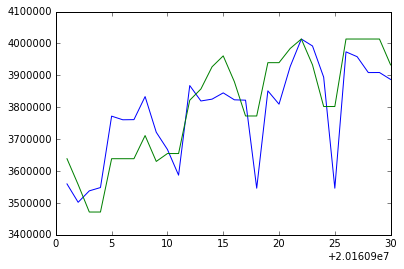

In [76]:
y2 = cur['predict_power_consumption'].values
x = cur['predict_date'].values
y = ref['predict_power_consumption'].values

plt.plot(x, y)
plt.plot(x,y2)
plt.legend()